# Advanced Modeling

In the Advanced Modeling phase, we'll look at different techniques that can be used to iteratively improve the baseline model. As said earlier, often, baseline models deliver 90% of value for 10% of the effort, so a lot of the improvements we'll be investigating will yield little to no improvement on the final model.

There are few methods that can be used for improving (an already good) baseline model:
- Feature analysis & selection. 
- Model selection.
- Hyperparameter tuning.

Alternatively, we could also look at techniques such as 'outlier removal' but these are unlikely to yield significant improvements as the data is already cleaned up.

## Data Loading
Import the required libraries to build a simple baseline model.

In [10]:
import sys
import math
import json
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from boruta import BorutaPy
%matplotlib inline
sys.path.insert(1, '../src/')
from utils import load_dataset_data
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score,auc

In [11]:
X_train, y_train, subject_train, X_test, y_test, subject_test = load_dataset_data()

## Feature analysis & selection
Feature analysis & selection, is the process of selecting a subset of relevant features for use in model development. Feature selection techniques are used for several reasons:
- they allow for simplification of models to make them easier to interpret
- they allow for shorter training times (smaller datasets require less training time)
- they avoid the curse of dimensionality & resultin  enhanced generalization by reducing overfitting

Note that we'll only be using the training data to perform feature selection, as we don't want to overfit any of the techniques to improve the model onto the test data.

Text(0.5, 1.05, 'Correlation Matrix')

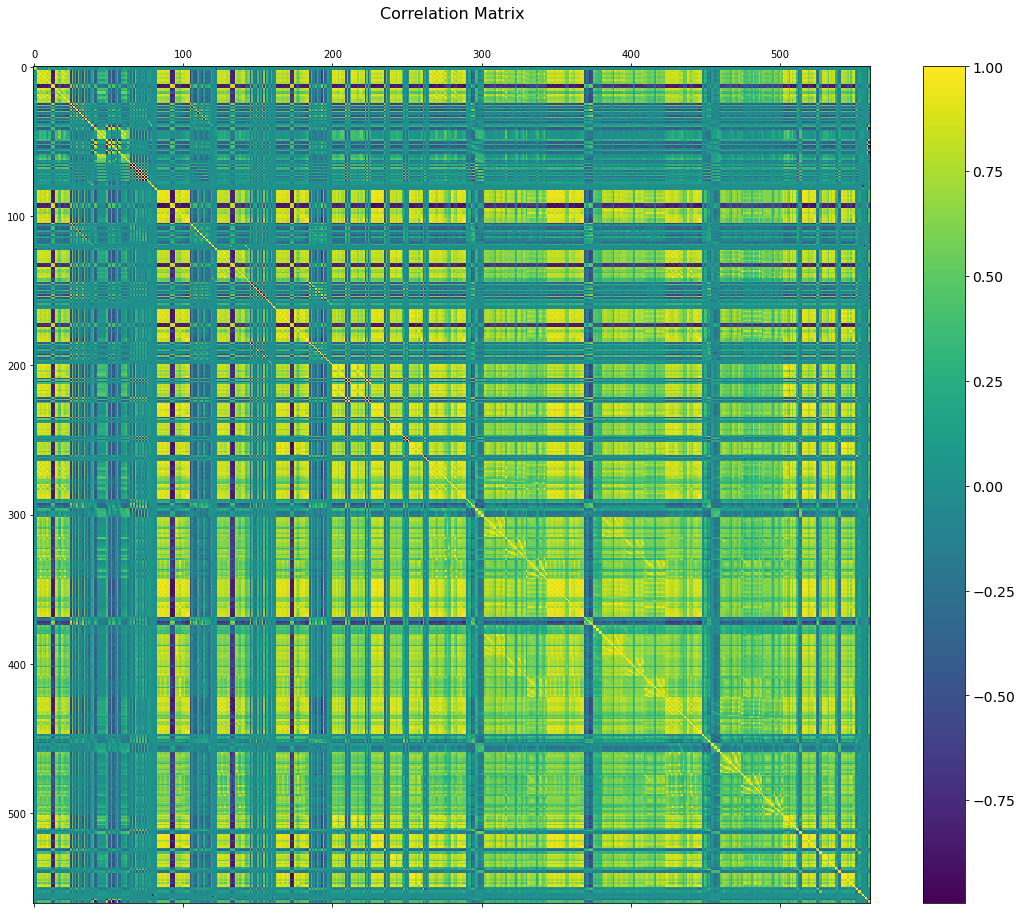

In [12]:
corr_matrix = X_train.corr()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

The large clusters of correlated features indicates that some of the features are very similar. Within each cluster, it probably suffices to select 1 feature for the model, as the other features will likely introduce unnecessary noise.

We'll investigate two approaches to select the relevant features:
- a filter method, 'Mutual Information'. In filter methods, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. In the 'Mutual Information' test, we compute the correlation between the categorical target and features, which is a proxy for how well the features predict the target.
- a wrapper method, 'Boruta'. In wrapper methods, we evaluate a subset of features using a machine learning algorithm that employs a search strategy to look through the space of possible feature subsets, evaluating each subset based on the quality of the performance of the given algorithm.

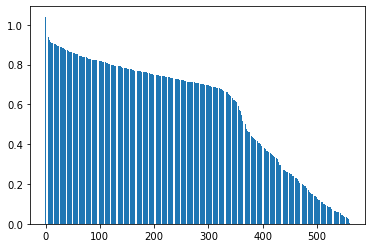

In [13]:
mi = mutual_info_classif(X_train, y_train.values.ravel())

mi_feature_importance = list(zip(X_train.columns, mi))
mi_feature_importance.sort(key = lambda x: -x[1])

mi_unimportant_features = [feature for (feature, mi) in mi_feature_importance if mi<0.1]

# plot mi feature importance
plt.bar([x for x in range(len(mi_feature_importance))], [x[1] for x in (mi_feature_importance)])
plt.show()

Clearly, some of the features are less important than others. For now, we'll filter out any features that drop below a Mutual Importance of 0.1. Let's investigate whether Boruta finds additional features that should be removed.

In [14]:
# Define a random forest classifier to evaluate whether a feature subset is good.
rf = RandomForestClassifier(n_jobs=4, class_weight='balanced', max_depth=5)

# Define Boruta feature selection method
boruta_feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Find all relevant features
boruta_feat_selector.fit(X_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	561
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	264
Tentative: 	201
Rejected: 	96
Iteration: 	9 / 100
Confirmed: 	264
Tentative: 	201
Rejected: 	96
Iteration: 	10 / 100
Confirmed: 	264
Tentative: 	201
Rejected: 	96
Iteration: 	11 / 100
Confirmed: 	264
Tentative: 	201
Rejected: 	96
Iteration: 	12 / 100
Confirmed: 	287
Tentative: 	178
Rejected: 	96
Iteration: 	13 / 100
Confirmed: 	287
Tentative: 	157
Rejected: 	117
Iteration: 	14 / 100
Confirmed: 	287
Tentative: 	157
Rejected: 	117
Iteration: 	15 / 100
Confirmed: 	287
Tentative: 	157
Rejected: 	117
Iteration: 	16 / 100
C

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=540, n_jobs=4,
                                          random_state=RandomState(MT19937) at 0x157D4853C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x157D4853C40, verbose=2)

In [15]:
boruta_unimportant_features = list(X_train.columns[~boruta_feat_selector.support_])

In [16]:
unimportant_features = {'boruta': boruta_unimportant_features, 'mi_unimportant_features': mi_unimportant_features}
with open('unimportant_features.json', 'w') as json_file:
    json.dump(unimportant_features, json_file)

In [17]:
with open('unimportant_features.json', 'r') as json_file:
    unimportant_features = json.load(json_file)
boruta_unimportant_features = unimportant_features['boruta']
mi_unimportant_features = unimportant_features['mi_unimportant_features']

In [18]:
len(set(boruta_unimportant_features)&set(mi_unimportant_features)), len(mi_unimportant_features), len(boruta_unimportant_features)

(44, 46, 256)

Boruta finds a larger set of unimportant features than mutual information. For the next experiment, we'll use the smallest set of informative features.

##  Model selection

Model selection is the task of selecting a statistical model from a list of candidate models. 
Given a range of candidate models with similar predictive power (e.g. F1 metric), the simplest model is most likely to be the best choice according to Occam's razor.

To avoid overfitting on the test data, we perform cross-validation on the train data. As we don't want to overfit on a specific user's data, we use LeaveOneGroupOut cross-validation. Specifically, this means that we train a model several times, on all users but one, and we validate the model performance on that user. This is repeated for all the users in the train set, and gives us a robust estimate of the model performance.

Note that some models require that the data is standardized to ensure model convergence. As such, after the unimportant features have been removed, we standarize each of the individual features.

In [19]:
names = ["Nearest Neighbors", "Linear SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "LogisticRegression"]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression()]
performance = {}

X_train_selected = X_train.drop(boruta_unimportant_features+mi_unimportant_features, axis=1)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_selected)

for name, clf in zip(names, classifiers):
    print(name)
    scores = cross_validate(clf, X=X_train_std, groups=subject_train.subjects.values, y=y_train, cv=GroupKFold(5), n_jobs=4, scoring='f1_macro')
    performance[clf] = scores
    print(np.mean(scores['test_score']))

Nearest Neighbors
0.7972439895797708
Linear SVM
0.813474331230872
Decision Tree
0.6895028800042177
Random Forest
0.7995893068114897
Neural Net
0.8146525486272962
AdaBoost
0.21223742972005288
Naive Bayes
0.6470533032865481
LogisticRegression
0.8149509273371051


##  Hyperparameter tuning

Hyperparameter tuning is the task of choosing a set of optimal hyperparameters for a machine learning algorithm or model. A hyperparameter, generally, is a parameter whose value is used to control the learning process. We'll investigate whether hyperparameter tuning has a significant effect in terms of performance for the Linear SVM.

In [ ]:
penalty = ['l1', 'l2']
loss = ['hinge', 'squared_hinge']
C = [0.0001,0.001, 0.01,0.1,1]
class_weight = ['balanced', None]
# Create the random grid
grid = {'penalty': penalty,
               'loss': loss,
               'C': C,
               'class_weight': class_weight}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
svc = LinearSVC()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svc_grid = GridSearchCV(estimator = svc, scoring='f1_macro', param_grid = grid, cv = GroupKFold(5), verbose=5, n_jobs = -1)
# Fit the random search model
svc_grid.fit(X_train_std, y_train.values.ravel(), groups=subject_train.subjects.values)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min


We plot the model performance across the parameter grid.

In [ ]:
test_scores = svc_grid.cv_results_['mean_test_score']
test_scores = test_scores[~np.isnan(test_scores)]
plt.boxplot(test_scores)

We select the best model and train it on the full training data with the optimized features and hyper parameters.

In [ ]:
sc = StandardScaler()
X_train_selected = X_train.drop(boruta_unimportant_features+mi_unimportant_features, axis=1)
X_train_std = sc.fit_transform(X_train_selected)

clf = svc_grid.best_estimator_.fit(X_train_std, y_train.values.ravel())

X_test_selected = X_test.drop(boruta_unimportant_features+mi_unimportant_features, axis=1)
X_test_std = sc.transform(X_test_selected)

y_pred_test = clf.predict(X_test_std)
y_pred_train = clf.predict(X_train_std)

In [ ]:
f1_score(y_pred_train, y_train, average='macro'), f1_score(y_pred_test, y_test, average='macro')

## Summary

The optimised SVC model gives us similar performance, but we are using less features and are overfitting less! This is especially important if we would like to implement a model that runs in real-time. In the real-time context, we often have to trade off speed for performance.

As this is still a linear model, training is fast, but we don't observe significant changes in performance. In the next notebook, we'll look at more complex models and optimization techniques.